# Simulation of quantitative phenotype given genotypes
Here we simulate effect size from mixture gaussian distribution and match strong effects with "heavily LD convoluted" SNPs.

## Utility functions
See code chunk below.

In [4]:
%%writefile ~/Documents/GTEx/SimUtils.py
import pandas as pd
import numpy as np
import os, random

def shuffle(df, axis=1):
    return df.apply(np.random.permutation, axis=axis)

class PhenotypeSimulator:
    def __init__(self, genotype_file):
        self.gfile = genotype_file
        self.phenotype = {}
        self.beta = {}
        self.pid = None
        
    def get_genes(self, limit = 5):
        res = pd.HDFStore(self.gfile).keys()
        if len(res) > limit:
            res = res[:limit]
        return res
    
    def get_X(self, table):
        return pd.read_hdf(self.gfile, table)
    
    def permute_X(self, tables, save_to):
        if os.path.isfile(save_to):
            os.remove(save_to)
        for table in tables:
            X = pd.read_hdf(self.gfile, table)
            X = shuffle(X)
            X.to_hdf(save_to, table, mode = 'a', complevel = 9, complib = 'zlib')
        self.gfile = save_to
    
    def get_ld(self, tables, save_to = None):
        '''r^2 based LD calculation'''
        ld = {table: pd.read_hdf(self.gfile, table).transpose().corr(method = 'pearson') for table in tables}
        ld = {key: (np.power(value, 2) * np.sign(value)).astype(np.float16) for key, value in ld.items()}
        if save_to is not None:
            if os.path.isfile(save_to):
                os.remove(save_to)
            for key in ld:
                ld[key].to_hdf(save_to, key, mode = 'a', complevel = 9, complib = 'zlib')
        return ld
    
    def load_ld(self, tables, fn):
        ld = {}
        for table in tables:
            ld[table] = pd.read_hdf(fn, table)
        return ld
    
    def ld_heatmap(self, corrmat, out):
        use_abs = np.sum((corrmat < 0).values.ravel()) == 0
        import seaborn as sns
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots()
        cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0, as_cmap=True)
        sns.heatmap(corrmat, ax = ax, cmap = cmap, vmin=-1 if not use_abs else 0, vmax=1, square=True, xticklabels = False, yticklabels = False)
        plt.savefig(out, dpi = 500)
        
    def generate_betamix(self, nbeta, mus, sigmas, pis, pi0 = 0):
        '''beta ~ \pi_0\delta_0 + \sum \pi_i N(0, sigma_i)
        sigma here is a nbeta list or nbeta * nbeta matrix
        '''
        if isinstance(sigmas, list):
            sigmas = np.diag(sigmas)
        assert (len(pis), len(pis)) == sigmas.shape
        masks = np.random.multinomial(1, pis, size = nbeta)
        mix = np.random.multivariate_normal(mus, sigmas, nbeta)
        return np.sum(mix * masks, axis = 1) * np.random.binomial(1, 1 - pi0, nbeta)
    
    def generate_y(self, X, beta, sigma, force = False):
        if self.pid in self.phenotype and force is not True:
            print('Name "{}" already exists. Use "force = True" to overwrite it'.format(self.pid))
            return self.phenotype[self.pid]
        assert X.shape[0] == len(beta)
        self.beta[self.pid] = beta.tolist()
        beta.reshape((len(beta),1))
        y = np.dot(X.T, beta) + np.random.normal(0, sigma, X.shape[1])
        y.reshape(len(y), 1)
        y = pd.DataFrame(data = y, columns = [self.pid], index = X.columns).transpose()
        self.phenotype[self.pid] = y
        return y
    
    def select_convoluted_snps(self, ld, cutoff1 = 0.8, cutoff2 = 10, cutoff3 = 0.01):
        '''based on LD matrix select SNPs in strong LD with other SNPs 
        yet are independent between themselves'''
        print('Count strong LD')
        strong_ld_count = ((np.absolute(ld) > cutoff1) * ld).sum(axis = 0).sort_values(ascending = False)
        strong_ld_count = strong_ld_count[strong_ld_count > cutoff2]
        print('Filter by LD')
        exclude = []
        for x in strong_ld_count.index:
            if x in exclude:
                continue
            for y in strong_ld_count.index:
                if y in exclude or y == x:
                    continue
                if np.absolute(ld[x][y]) > cutoff3:
                    exclude.append(y)
        print('Done')
        return [i for i, x in enumerate(strong_ld_count.index) if not x in exclude]
    
    def swap_beta(self, beta, strength_index):
        '''Set tops of beta to tops in strength_index'''
        nb = [0] * len(beta)
        beta = sorted(beta, key=abs, reverse=True)
        for item in strength_index:
            nb[item] = beta.pop(0)
        random.shuffle(beta)
        for idx in range(len(nb)):
            if not idx in strength_index:
                nb[idx] = beta.pop(0)
        assert len(beta) == 0
        return np.array(nb)
    
    def set_id(self, name):
        self.pid = name

        
class BetaDist:
    '''Reproducing simulated distributions of Stephens 2017 (ASH paper)'''
    def __init__(self):
        self.pi0 = 0
        self.pis = [None]
        self.mus = [None]
        self.sigmas = [None]
        
    def set_pi0(self, pi0):
        self.pi0 = pi0
        
    def set_spiky(self):
        self.pis = [0.4,0.2,0.2,0.2]
        self.mus = [0,0,0,0]
        self.sigmas = [0.25,0.5,1,2]
    
    def set_near_normal(self):
        self.pis = [2/3,1/3]
        self.mus = [0,0]
        self.sigmas = [1,2]
        
    def set_flat_top(self):
        self.pis = [1/7] * 7
        self.mus = [-1.5, -1, -.5 , 0, .5, 1, 1.5]
        self.sigmas = [0.5] * 7
        
    def set_skew(self):
        self.pis = [1/4,1/4,1/3,1/6]
        self.mus = [-2,-1,0,1]
        self.sigmas = [2,1.5,1,1]
        
    def set_big_normal(self):
        self.pis = [1]
        self.mus = [0]
        self.sigmas = [4]

    def set_bimodal(self):
        self.pis = [0.5, 0.5]
        self.mus = [-2, 2]
        self.sigmas = [1, 1]
        
    def __str__(self):
        params = ' + '.join(["{} N({}, {}^2)".format(x,y,z) for x, y, z in zip(self.pis, self.mus, self.sigmas)])
        return '{:.3f} \delta_0 + {:.3f} [{}]'.format(self.pi0, 1 - self.pi0, params)

Writing /home/gaow/Documents/GTEx/SimUtils.py


In [24]:
[global]
parameter: genotype_data = '~/Documents/GTEx/ToyExample/3mashgenes.genotype.h5'
parameter: cwd = '~/Documents/GTEx'
parameter: pi0 = [0.995]
parameter: shape = ['spiky']
parameter: n_rep = 1
parameter: permute_genotype = "False"

## Step 1: compute and save LD

In [10]:
%sosrun genotype_LD -v4
[genotype_LD]
# Permute (or not) X & Get LD structure
input: genotype_data, group_by = 1
output: "${_input!an}.ld.h5" if permute_genotype == 'False' else "${_input!an}.permuted.ld.h5"
task: workdir = cwd
python:
  import os, sys
  from SimUtils import PhenotypeSimulator, BetaDist
  ms = PhenotypeSimulator(${_input!ar})
  tables = ms.get_genes()
  if ${permute_genotype}:
     ms.permute_X(tables, save_to = '${_output!nn}.h5')
  ld = ms.get_ld(tables, save_to = ${_output!r})
  for table in tables:
      ms.ld_heatmap(ld[table].iloc[:1000,:1000], ${_input!anr} + '.{}.ld.png'.format(os.path.basename(table) + ('.permuted' if ${permute_genotype} else '')))

DEBUG: Workflow genotype_LD created with 1 sections: genotype_LD_0
TRACE: /opt/miniconda3/lib/python3.6/site-packages/sos-0.9.8.10-py3.6.egg/sos/site_config.yml does not exist
TRACE: config.yml does not exist
DEBUG: Args "${_input!an}.ld.h5" if permute_genotype == 'False' else "${_input!an}.permuted.ld.h5"
 cannot be determined: name 'permute_genotype' is not defined
DEBUG: Args "${_input!an}.ld.h5" if permute_genotype == 'False' else "${_input!an}.permuted.ld.h5"
 cannot be determined: name 'permute_genotype' is not defined
DEBUG: Executing genotype_LD_0: Permute (or not) X & Get LD structure
DEBUG: input:    ['/home/gaow/Documents/GTEx/ToyExample/3mashgenes.genotype.h5']


1 task completed: 3b23

INFO: 3b23423743dc7c5effc8d36ecec7ac7c.out:


INFO: 3b23423743dc7c5effc8d36ecec7ac7c.err:


2017-08-28 21:48:36,913: INFO: 3b23423743dc7c5effc8d36ecec7ac7c ``started``
Closing remaining open files:/home/gaow/Documents/GTEx/ToyExample/3mashgenes.genotype.h5...done
2017-08-28 21:52:29,251: INFO: 3b23423743dc7c5effc8d36ecec7ac7c ``completed``



DEBUG: Collect shared result {0: {}}
DEBUG: output:   ['/home/gaow/Documents/GTEx/ToyExample/3mashgenes.genotype.ld.h5']
DEBUG: Workflow genotype_LD (ID=2526139dbfb70e1a) is executed successfully.


> %preview /home/gaow/Documents/GTEx/ToyExample/3mashgenes.genotype.ENSG00000264247.ld.png

> /home/gaow/Documents/GTEx/ToyExample/3mashgenes.genotype.ENSG00000264247.ld.png (1.5 MiB):

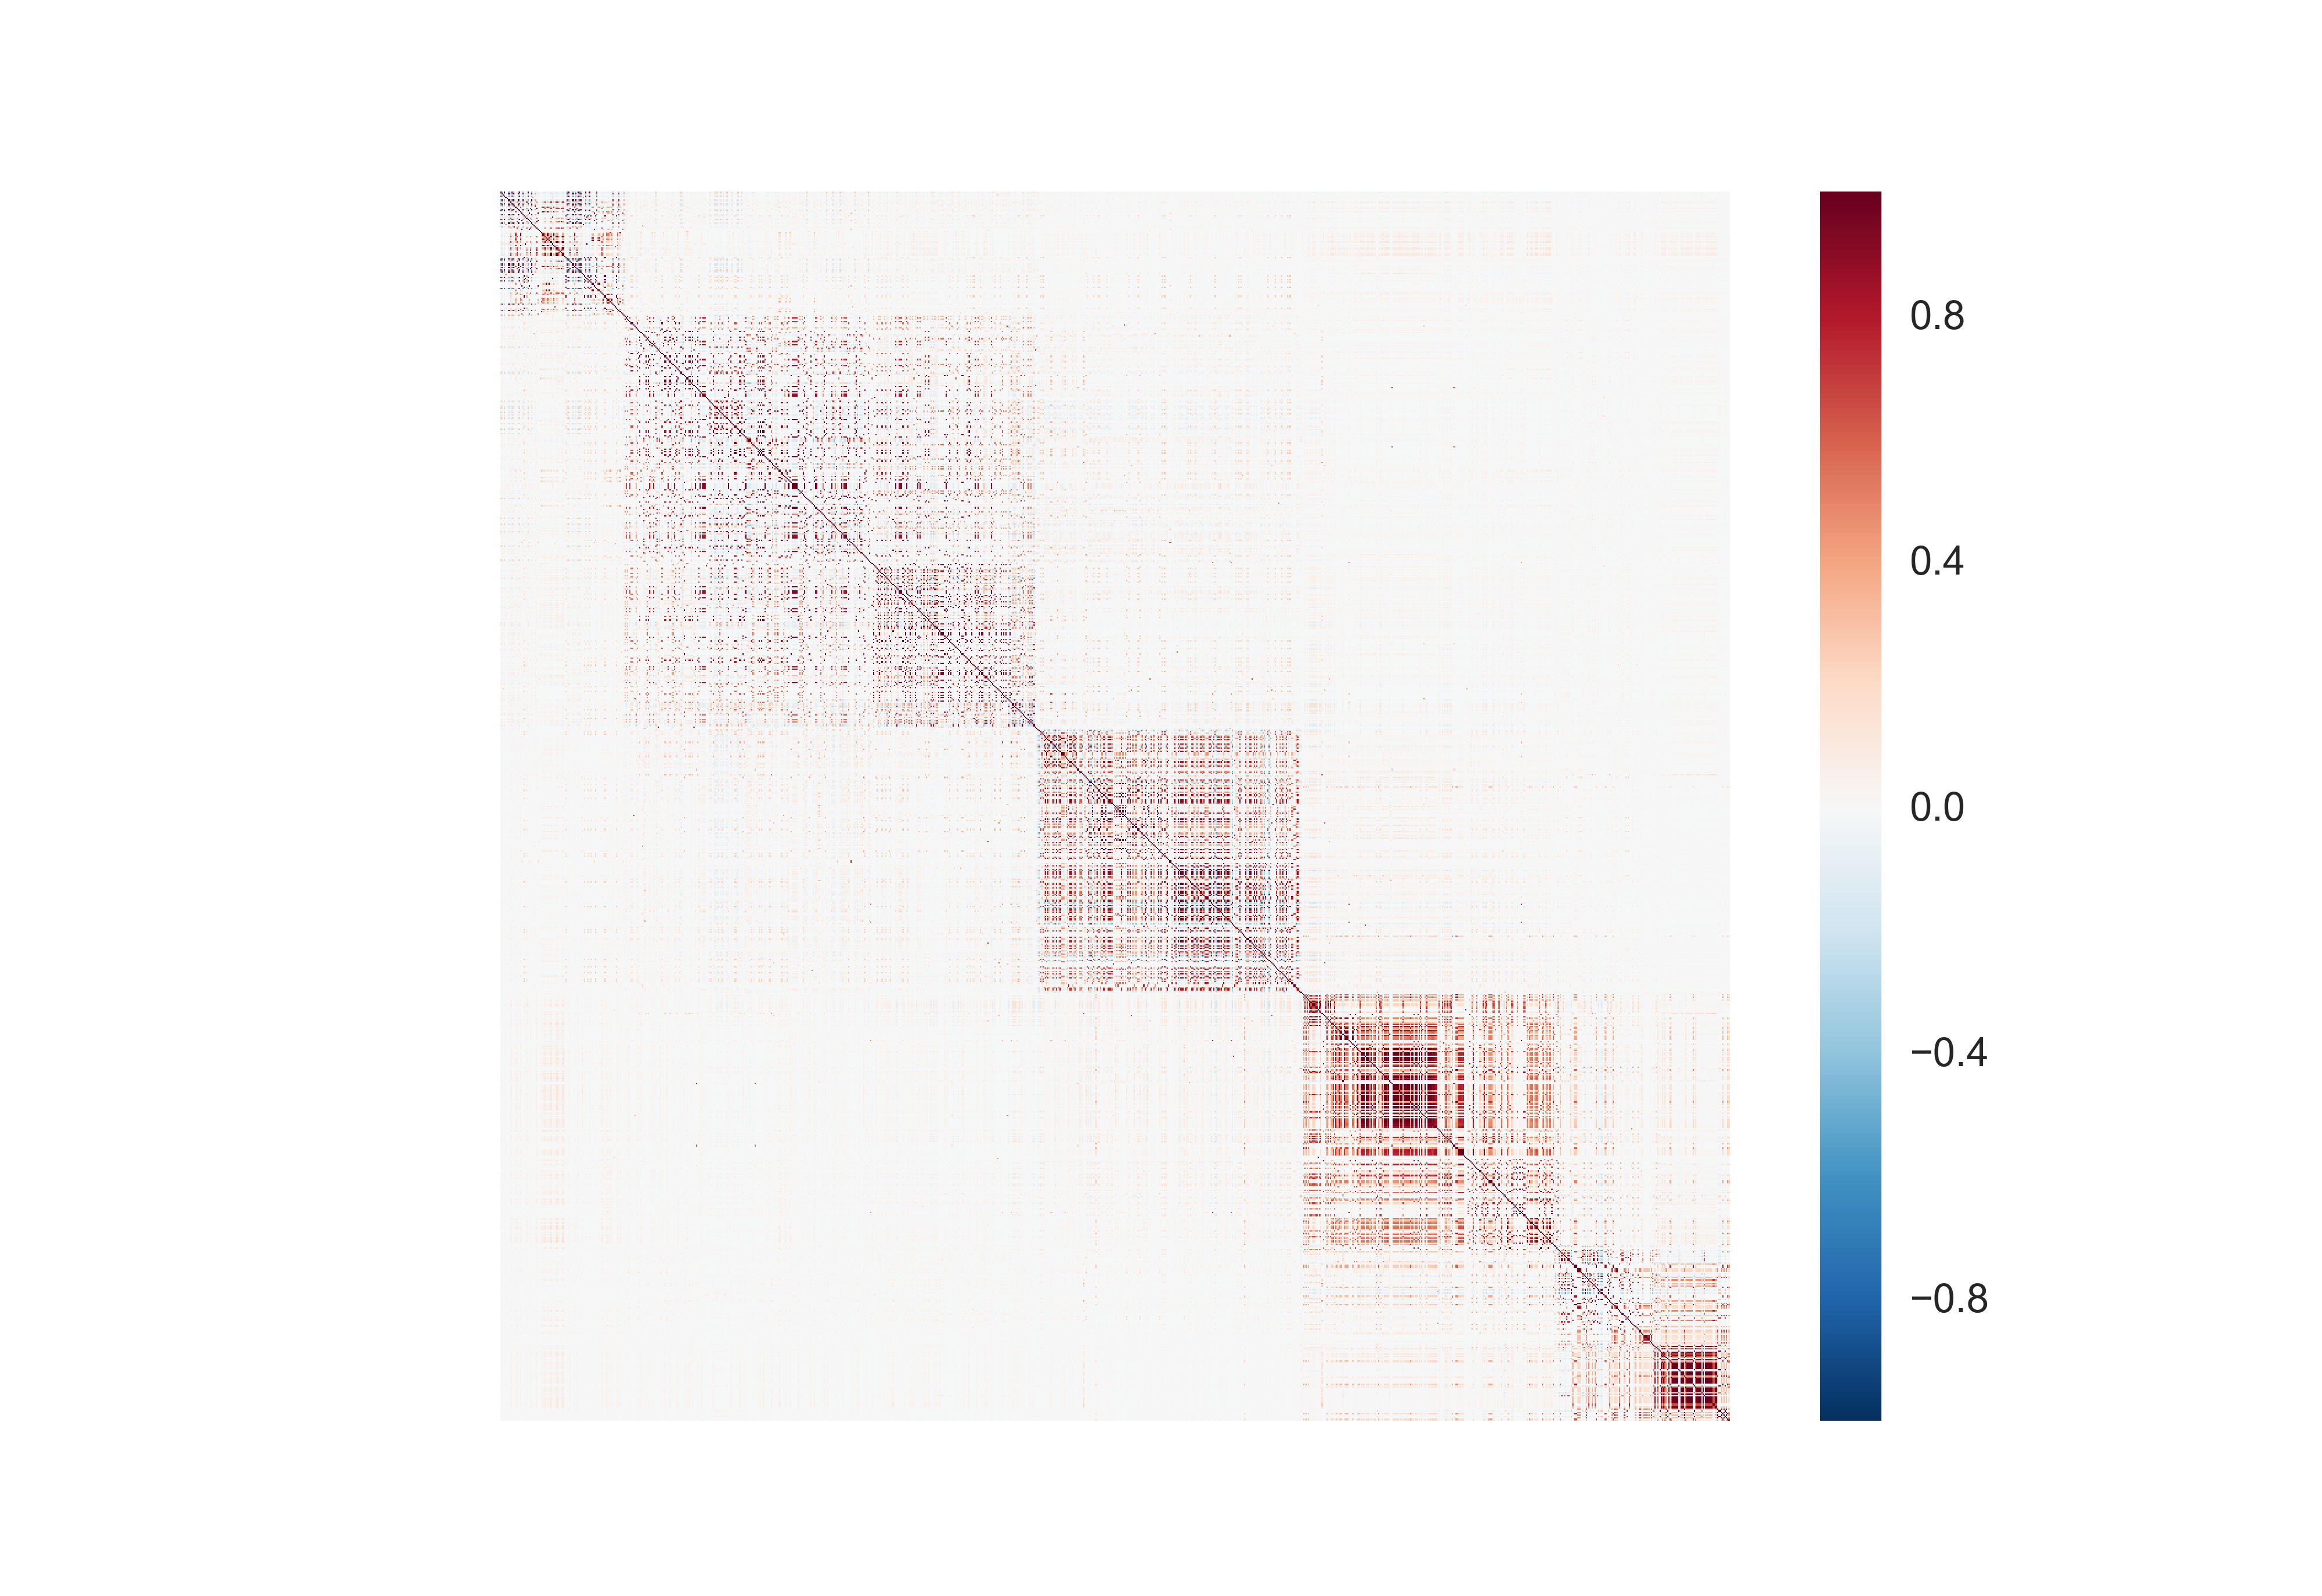

In [17]:
%preview ${genotype_data!an}.ENSG00000264247.ld.png

> %preview /home/gaow/Documents/GTEx/ToyExample/3mashgenes.genotype.ENSG00000267508.ld.png

> /home/gaow/Documents/GTEx/ToyExample/3mashgenes.genotype.ENSG00000267508.ld.png (1.7 MiB):

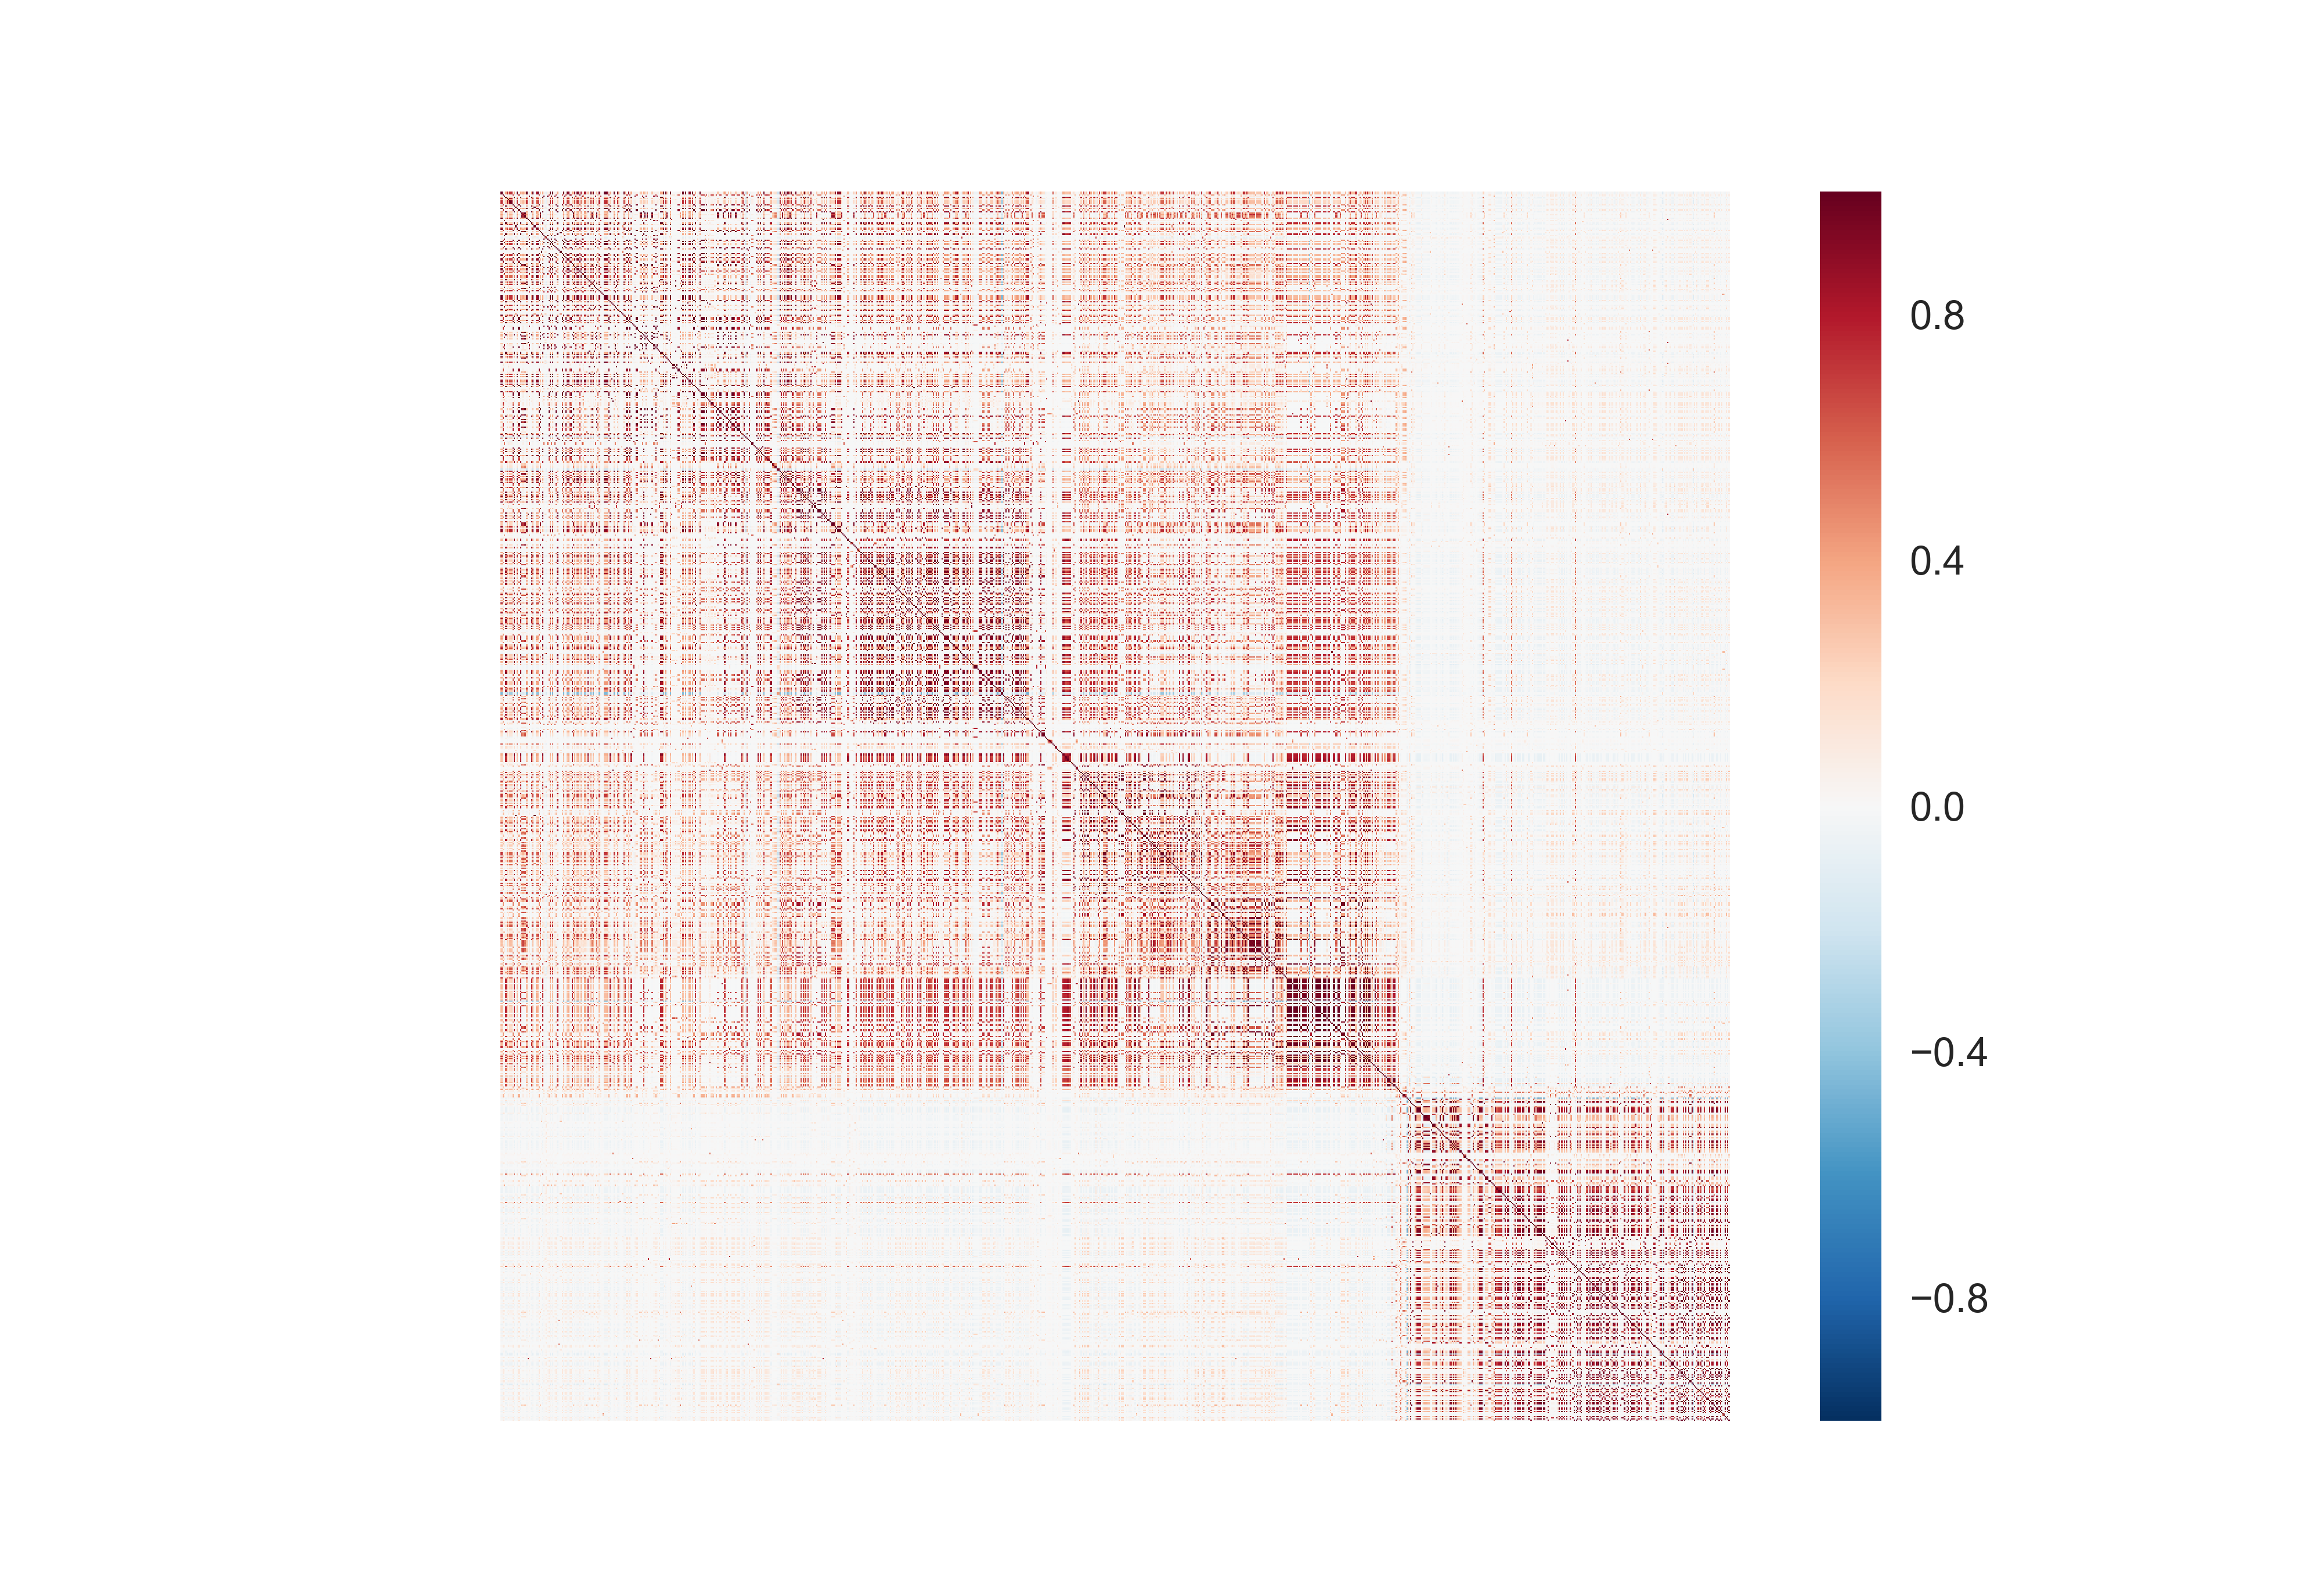

In [21]:
%preview ${genotype_data!an}.ENSG00000267508.ld.png

> %preview /home/gaow/Documents/GTEx/ToyExample/3mashgenes.genotype.ENSG00000145214.ld.png

> /home/gaow/Documents/GTEx/ToyExample/3mashgenes.genotype.ENSG00000145214.ld.png (1.5 MiB):

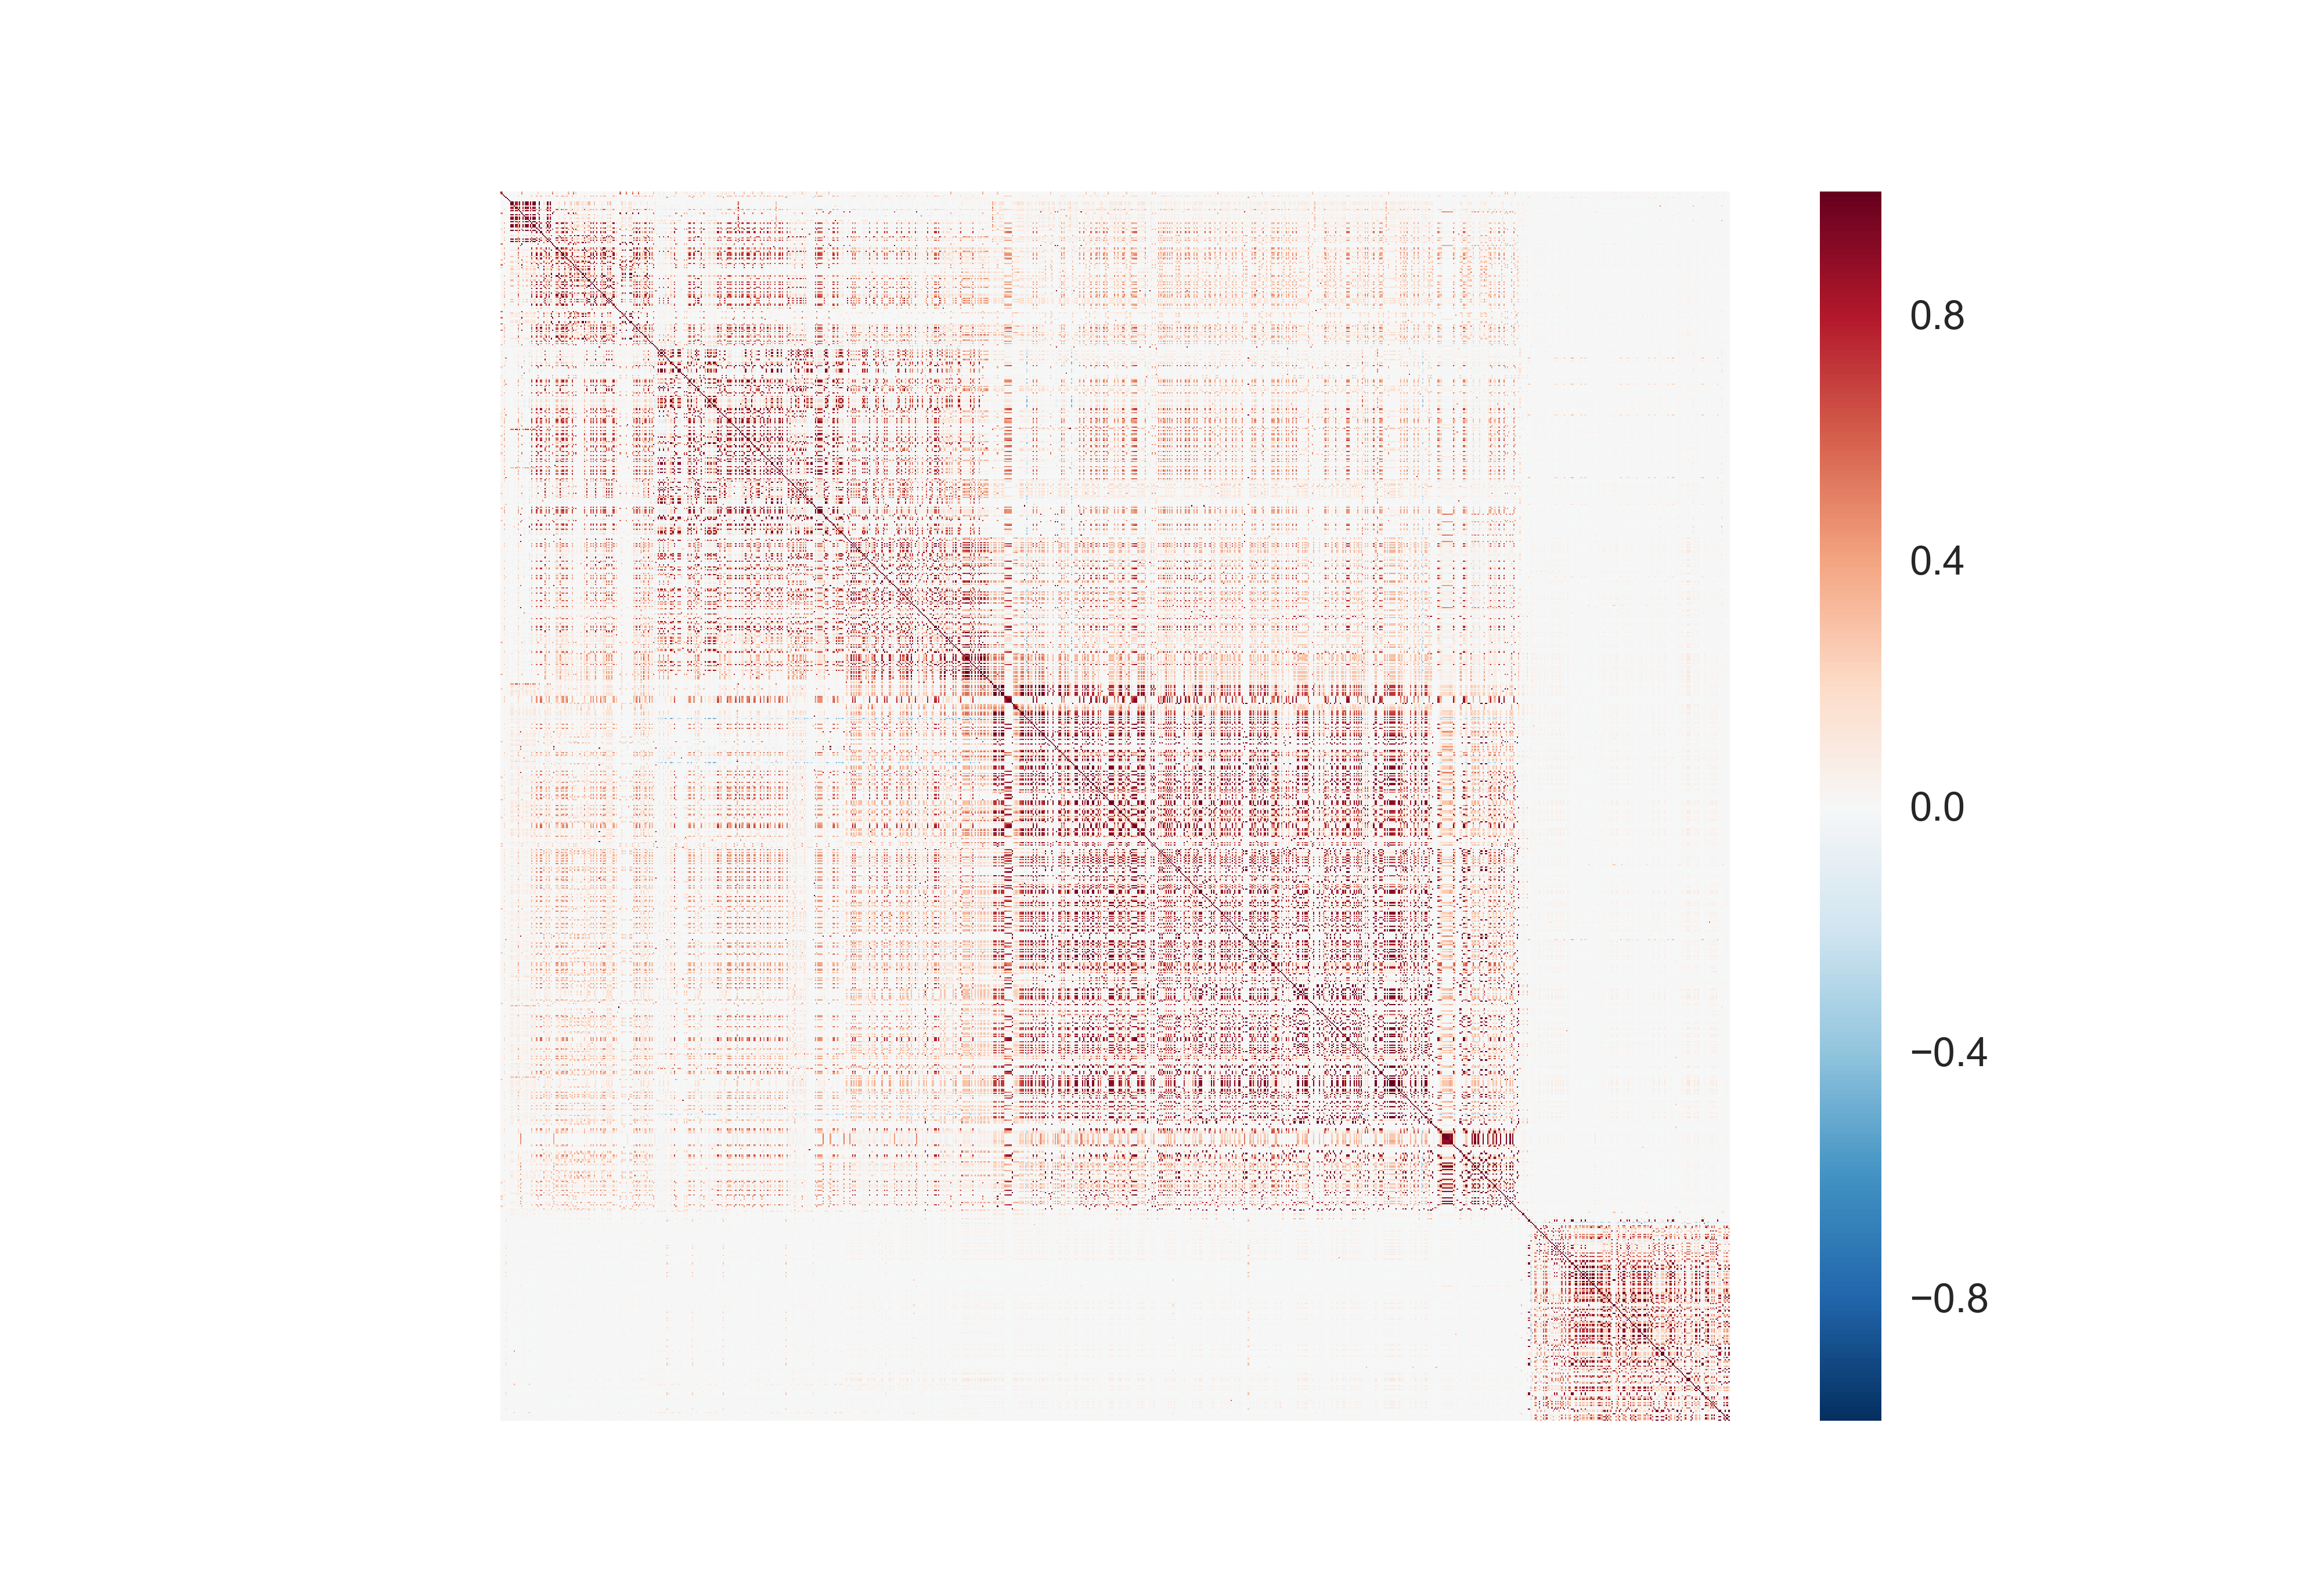

In [19]:
%preview ${genotype_data!an}.ENSG00000145214.ld.png

## Step 2: simulate phenotype
It breaks down to 3 sub-steps:

* Simulating effect size, ie, $\beta$ in the linear model $ Y = X \beta + E$ where for simplicity we assume $E_{ij} \sim N(0,1)$. We sample $\beta$ from a mixture of gaussian distribution ($1-\pi_0$) and a point mass at zero ($\pi_0$).
* Swap big effect size to most LD-convoluted SNPs: to better illustrate the potential of mr-ash I identify from genotype matrix potentially the more LD-convoluted SNPs and assign them the largest effect size. Specifically, I rank SNPs by their number of having LD with other SNPs greater than 0.9 (unsigned), and filter the top ranked SNPs until there is no strong LD between them ($r^2<0.1$). Then I swap $\beta$s so that these SNPs have large effect size.
* Simulate phenotypes: regression model

In [29]:
[simulate]
input_files = genotype_data if permute_genotype == 'False' else [x.replace(".h5", ".permuted.h5") for x in genotype_data]
replicate = [x + 1 for x in range(n_rep)]
input: input_files, group_by = 1, for_each = ['pi0', 'shape', 'replicate']
output: "${cwd!a}/${_input!bn}.simulated/${_input!bn}." + "${_pi0}_${_shape}_${_replicate}".replace('.', 'p') + '.expr.h5'
task: workdir = cwd
python:
  import sys, os, json, pandas as pd
  from SimUtils import PhenotypeSimulator, BetaDist
  ms = PhenotypeSimulator(${_input!ar})
  tables = ms.get_genes()
  ld = ms.load_ld(tables, "${_input!an}.ld.h5")
  if os.path.isfile(${_output!r}):
     os.remove(${_output!r})
  param = BetaDist()  
  param.set_pi0(${_pi0})
  param.set_${_shape}()
  print(param)
  for table in tables:
    ms.set_id(os.path.basename(table))
    nbeta = ld[table].shape[0]
    beta = ms.generate_betamix(nbeta=nbeta,pi0=param.pi0, pis=param.pis, mus = param.mus, sigmas=param.sigmas)
    if not ${permute_genotype}:
       strong_snps_idx = ms.select_convoluted_snps(ld[table])
       beta = ms.swap_beta(beta, strong_snps_idx)
    X = ms.get_X(table=table)
    y = ms.generate_y(beta=beta,sigma=1, X=X, force = True)
  pd.concat(ms.phenotype.values()).to_hdf(${_output!r}, '/simulated', mode = 'a', complevel = 9, complib = 'zlib')
  meta = {'pi': param.pis, 'pi0': param.pi0, 'sigma': param.sigmas, 'mu': param.mus, 'beta': ms.beta, 'name': ${_shape!r}}
  with open("${_output!n}.json", 'w') as fp:
    json.dump(meta, fp)

In [31]:
%sosrun simulate -J 8

1 task completed: 4b5d

In [32]:
%sessioninfo

Session Info 
 SoS 
 
 
 SoS Version 0.9.8.10 
 
 
 pandas 0.20.2 
 
 
 numpy 1.13.1 
 
 
 Python3 
 
 
 Kernel python3 
 
 
 Language Python3 
 
 
 Version 3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]